In [83]:
"""
Create dictionary from potku with 

Nils Wikström
2024-02-16

"""

import os
import re
#------------------------------------------------------------------------------
import numpy as np                       ## for handling of data
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import json
#------------------------------------------------------------------------------
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['k','r','g','b']) 
plt.rcParams['figure.autolayout'] = True
#------------------------------------------------------------------------------
#import ImportData as ID
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# --- element dictionary -----------------------------------
#------------------------------------------------------------------------------
element = {
	'N':{'A':14,'Z':7},
	'Si':{'A':28,'Z':14},
	'Cl':{'A':35,'Z':17},
	'Ti':{'A':48,'Z':22},
	'Cu':{'A':63,'Z':29},
	'Br':{'A':79,'Z':35},
	'Mo':{'A':96,'Z':42},
	'Ag':{'A':107,'Z':47},
	'I':{'A':127,'Z':53},
	'Ta':{'A':181,'Z':73},
	'Au':{'A':197,'Z':79}
	}
#------------------------------------------------------------------------------

In [84]:
def  read_columns(root):
    columns =  []
    with open(root,'r') as depthprofiles:
        lines = depthprofiles.readlines()
        for line in lines:
            column_data = line.split()
            for i,  column_data in enumerate(column_data):
                if len(columns) <= i:
                    columns.append([])
                columns[i].append(float(column_data.strip()))
    return columns

In [85]:
def linfit(x,y):
    
    threshold_value = 0.5 #Start linreg after this value
    index = next((i for i, x in enumerate(y) if x > threshold_value), 0) #find index
    x_min = x[index] #starting x value
    x_max = 3000 
    x_filter = [x_dat for x_dat in x if x_min <= x_dat <= x_max] #filter x data
    y_filter = y[x.index(x_filter[0]):x.index(x_filter[-1])+1] #filter y data
    coeff = np.polyfit(x_filter,y_filter,1) 
    polyf = np.poly1d(coeff)
    x_fit = np.linspace(min(x_filter),max(x_filter),100)
    y_fit = polyf(x_fit)
    b = coeff[0]  #slope
    
    return x_fit,y_fit, b


In [86]:
def get_slope(x,y):
    _,_,slope = linfit(x,y)
    return(slope)

In [91]:
def plot_profiles(data):
    i = 0
    for sample in data['Samples']: #Iterate over samples
        if len(data['Samples'][sample]) > 0: #Check that it has data
            plt.figure(i)
            plt.title(sample)
            plt.xlim([-500,   3000])
            plt.ylim([0.0, 1.2])
            plt.xlabel('depth [10$^{15}$ atoms/cm$^2$]')
            plt.ylabel('atomic fraction')
            plt.grid(linestyle='--')
            for depth in data['Samples'][sample]: #plot data
                x = data['Samples'][sample][depth]['x']
                c = data['Samples'][sample][depth]['C']
                plt.plot(x, c, label = depth)
                x_fit, c_fit,b = linfit(x, c) #do a linear fit
                plt.plot(x_fit,c_fit)
                plt.legend()
            i = i+1

In [92]:
folder_path = '/Users/niwi9751/potku/requests/'
def Initialize_Profile(folder_path):
    if '.potku' in folder_path:                     #Check if potku is in the path name
        print('Folder is compatible, proceeding')   
        files = os.listdir(folder_path)             #Make list of folders in the request
    else:                                           
        print('Searching directory for potku files') #Search for potku files
        possible_files = [file for file in os.listdir(folder_path) if '.potku' in file] #make list of possible files
        
    if len(possible_files) == 0:                #if none are found, tell you
        print('Could not find .potku file, please try again')
    elif len(possible_files) == 1:              #if only one, make list of the files
        files = os.listdir(folder_path + possible_files[0])
        print(files)
    else:
        print('Found compatible files: ')       
        [print(str(i + 1) + '.' + possible_files[i]) for i in range(len(possible_files))] #print list of possible files
        choise = possible_files[int(input('Chose the file you want (1 - ' + str(len(possible_files)) + ')'))-1]
        folder_path = folder_path + choise #chose one of them
    
    dict = {'Beam':{}, 'Samples':{}, 'Settings':{}} #Create dictionary
    
    try:
        beamdata = json.load(open(folder_path +'/Default/Default.measurement')) #Load info from folders
        beamprofile = json.load(open(folder_path+'/Default/Default.profile'))
        dict['Beam']['Ion'] = re.sub(r'\d+', '', beamdata['beam']['ion']) #Assign data
        dict['Beam']['Mass'] = re.sub(r'[a-zA-z]',  '' , beamdata['beam']['ion'])
        dict['Beam']['Energy'] = beamdata['beam']['energy']
        dict['Settings']['Num_step'] = beamprofile['depth_profiles']['number_of_depth_steps']
        dict['Settings']['Stop_step'] = beamprofile['depth_profiles']['depth_step_for_stopping']
        dict['Settings']['Out_step'] = beamprofile['depth_profiles']['depth_step_for_output']
    except:
        print('Corrupt Default.profile or Default.measurement file, please check them')
    
    
    
    
    for root, dirs, files in os.walk(folder_path):#Check all files in folder path
        for file in files:
            if file.endswith('.info'): #If infofile, we are in the right directory, keep looking here!!!
                currentsample = file.removesuffix('.info')
                dict['Samples'][currentsample] = {}  #Make it a sample
            if file.startswith('depth.') and 'total' not  in file: #Find the corresponding depht profiles, and save them.
                newroot = root.replace(os.path.sep,  '/') + '/' + file
                depthprofile = file.removeprefix('depth.')
                columns =  read_columns(newroot)
                if len(columns)== 7:
                    dict['Samples'][currentsample][depthprofile] = {'x': columns[0], 'C': columns[3],'NoNormC': columns[4],'N': columns[6]}
    return dict


Searching directory for potku files
Found compatible files: 
1.20240205KrXe-in-ZrO2.potku
2.20240205KrXe-in-ZrO2.potku - Copy
3.AtKTHKrXeImp.potku
4.CheckThatIGotIt.potku
5.Test.potku
6.ToF-ERDA-KrXeTa-Ag36MeV.potku
7.ToF-ERDA-KrXeTa-Cl24MeV.potku
8.ToF-ERDA-KrXeTa-I24MeV.potku
9.ToF-ERDA-KrXeTa-I36MeV.potku
Corrupt Default.profile or Default.measurement file, please check them
2.8644127579737348e-05
-4.7260889877641747e-05
0.0
1.300069418386492e-05
-0.000365774112903226
-5.43400656814451e-05
-2.4145538461538494e-05
-0.000160064827586207
-0.00033344651835372663


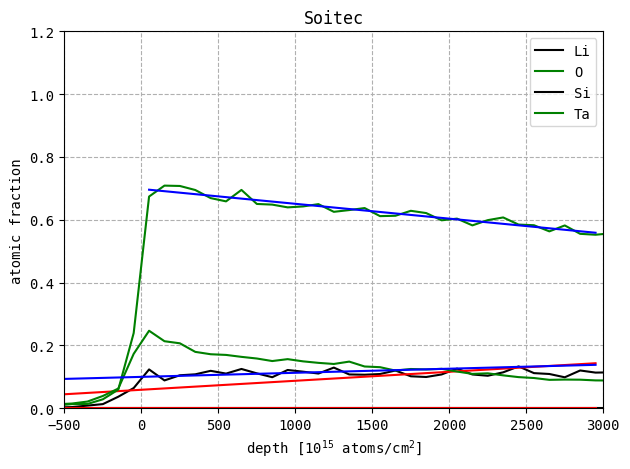

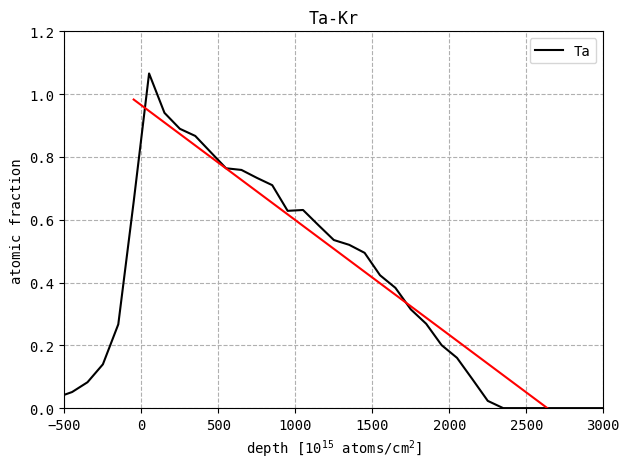

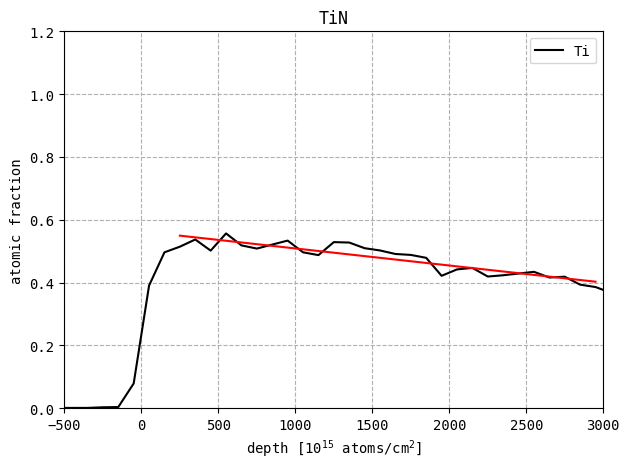

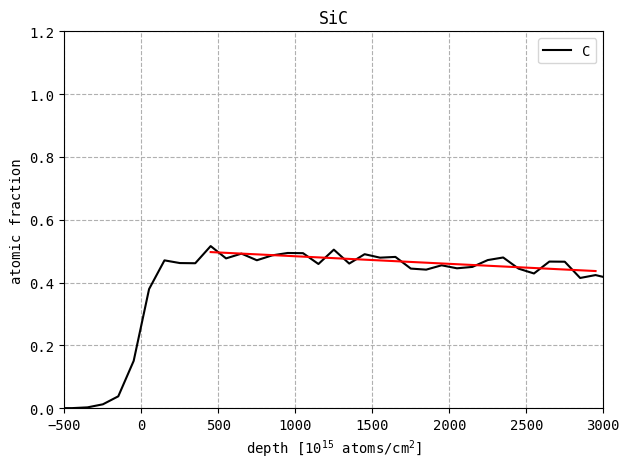

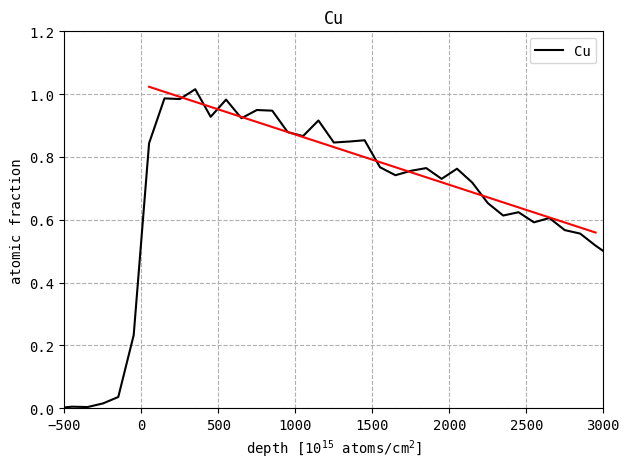

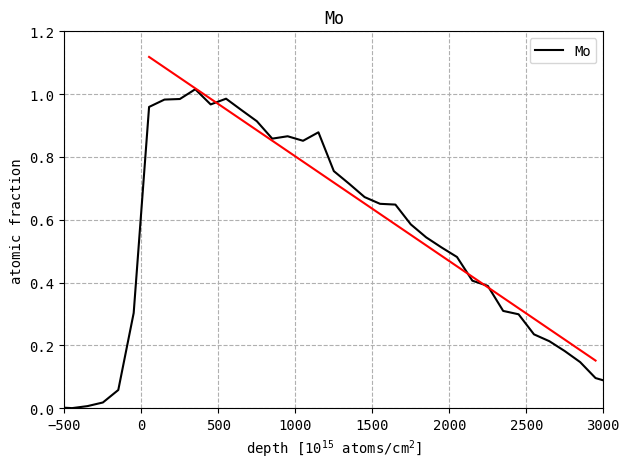

In [93]:
data = Initialize_Profile(folder_path)
plot_profiles(data)

